In [1]:
import os
import io
import requests

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

PROJ_PATH = '/home/reese56/w266_final/'
VOTEVIEW = os.path.join(PROJ_PATH, 'data/voteview/')
VOTEVIEW_RAW = os.path.join(VOTEVIEW, 'data/voteview/raw/')
SAVE_PATH = os.path.join(VOTEVIEW, 'gen/')

In [2]:
# import voteview congressional vote data
combined_votes = pd.read_csv(os.path.join(VOTEVIEW, 'gen/combined_votes.csv'))

In [3]:
party_votes = (combined_votes
               .groupby(['congress','chamber','rollnumber','bill_number','party_code','cast'], as_index = False)
               .agg({'status':'count',
                     'dem_count':'first',
                     'gop_count':'first',})
               .rename({'status':'party_votes'}, axis = 1)
              )
party_votes

,congress,chamber,rollnumber,bill_number,party_code,cast,party_votes,dem_count,gop_count
0,75,House,2,SJR3,100,abstention,15,332.0,89.0
1,75,House,2,SJR3,100,yea,317,332.0,89.0
2,75,House,2,SJR3,200,abstention,6,332.0,89.0
3,75,House,2,SJR3,200,yea,83,332.0,89.0
4,75,House,3,S416,100,abstention,34,332.0,89.0
...,...,...,...,...,...,...,...,...,...
247613,114,Senate,502,S612,100,nay,13,44.0,54.0
247614,114,Senate,502,S612,100,yea,31,44.0,54.0
247615,114,Senate,502,S612,200,abstention,1,44.0,54.0
247616,114,Senate,502,S612,200,nay,7,44.0,54.0


In [4]:
party_votes['cast'] = np.where(party_votes['cast'] == 'abstention',
                               'abstain',
                                party_votes['cast'])
party = {'dem':100, 'gop':200}

for prty in ['dem', 'gop']:
    prty_bool = party_votes['party_code'] == party[prty]
    for cst in ['yea','nay','abstain']:
        party_votes[cst +'_'+ prty] = np.where((party_votes['cast'] == cst) & prty_bool,
                                           party_votes['party_votes'], 0)

vote_prod = (party_votes
               .groupby(['congress','chamber','rollnumber','bill_number'], as_index = False)
               .agg({'dem_count':'first',
                     'gop_count':'first',
                     'yea_dem':np.sum,
                     'nay_dem':np.sum,
                     'abstain_dem':np.sum,
                     'yea_gop':np.sum,
                     'nay_gop':np.sum,
                     'abstain_gop':np.sum})
              )

for prty in ['dem', 'gop']:
    for cst in ['yea','nay','abstain']:
        vote_prod[cst +'_'+ prty] = vote_prod[cst +'_'+ prty]/vote_prod[prty + '_count']
    
vote_prod

,congress,chamber,rollnumber,bill_number,dem_count,gop_count,yea_dem,nay_dem,abstain_dem,yea_gop,nay_gop,abstain_gop
0,75,House,2,SJR3,332.0,89.0,0.954819,0.000000,0.045181,0.932584,0.000000,0.067416
1,75,House,3,S416,332.0,89.0,0.003012,0.894578,0.102410,0.887640,0.101124,0.011236
2,75,House,4,HR1531,332.0,89.0,0.259036,0.620482,0.114458,0.853933,0.067416,0.078652
3,75,House,5,HR1531,332.0,89.0,0.063253,0.819277,0.111446,0.910112,0.022472,0.067416
4,75,House,6,HR3587,332.0,89.0,0.695783,0.150602,0.147590,0.044944,0.865169,0.089888
...,...,...,...,...,...,...,...,...,...,...,...,...
46137,114,Senate,498,S2943,44.0,54.0,0.909091,0.090909,0.000000,0.944444,0.037037,0.018519
46138,114,Senate,499,HR2028,44.0,54.0,0.386364,0.613636,0.000000,0.796296,0.185185,0.018519
46139,114,Senate,500,HR2028,44.0,54.0,0.500000,0.500000,0.000000,0.740741,0.240741,0.018519
46140,114,Senate,501,S612,44.0,54.0,0.545455,0.454545,0.000000,0.833333,0.148148,0.018519


In [5]:
def bp_score(df):
    yea = df['yea_dem']*df['yea_gop']
    nay = df['nay_dem']*df['nay_gop']
    return np.max([yea, nay])


vote_prod['bp_score'] = vote_prod.apply(lambda df: bp_score(df) + 0.001, axis = 1)
vote_prod['pu_dem'] = vote_prod.apply(lambda df: max(df['yea_dem'],df['nay_dem']), axis = 1)
vote_prod['pu_gop'] = vote_prod.apply(lambda df: max(df['yea_gop'],df['nay_gop']), axis = 1)
vote_prod

,congress,chamber,rollnumber,bill_number,dem_count,gop_count,yea_dem,nay_dem,abstain_dem,yea_gop,nay_gop,abstain_gop,bp_score,pu_dem,pu_gop
0,75,House,2,SJR3,332.0,89.0,0.954819,0.000000,0.045181,0.932584,0.000000,0.067416,0.891449,0.954819,0.932584
1,75,House,3,S416,332.0,89.0,0.003012,0.894578,0.102410,0.887640,0.101124,0.011236,0.091463,0.894578,0.887640
2,75,House,4,HR1531,332.0,89.0,0.259036,0.620482,0.114458,0.853933,0.067416,0.078652,0.222199,0.620482,0.853933
3,75,House,5,HR1531,332.0,89.0,0.063253,0.819277,0.111446,0.910112,0.022472,0.067416,0.058567,0.819277,0.910112
4,75,House,6,HR3587,332.0,89.0,0.695783,0.150602,0.147590,0.044944,0.865169,0.089888,0.131296,0.695783,0.865169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46137,114,Senate,498,S2943,44.0,54.0,0.909091,0.090909,0.000000,0.944444,0.037037,0.018519,0.859586,0.909091,0.944444
46138,114,Senate,499,HR2028,44.0,54.0,0.386364,0.613636,0.000000,0.796296,0.185185,0.018519,0.308660,0.613636,0.796296
46139,114,Senate,500,HR2028,44.0,54.0,0.500000,0.500000,0.000000,0.740741,0.240741,0.018519,0.371370,0.500000,0.740741
46140,114,Senate,501,S612,44.0,54.0,0.545455,0.454545,0.000000,0.833333,0.148148,0.018519,0.455545,0.545455,0.833333


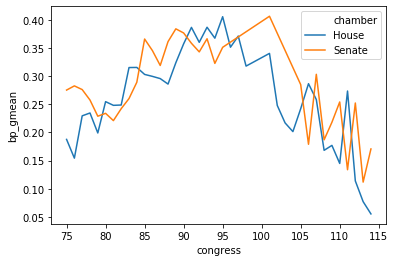

In [18]:
from scipy.stats import gmean, hmean
import seaborn as sns

bp_means = (vote_prod.groupby(['congress','chamber'])
            .agg(bp_amean = ('bp_score',np.mean),
                 bp_gmean = ('bp_score',gmean))
            .reset_index()
           )

sns.lineplot(x = 'congress', y = 'bp_gmean', hue = 'chamber', data = bp_means)

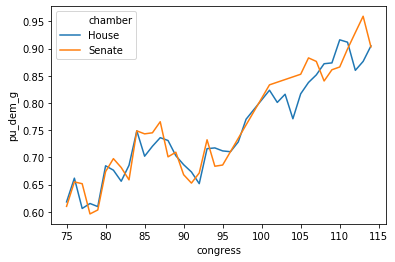

In [17]:
pu_dem_means = (vote_prod.groupby(['congress','chamber'])
            .agg(pu_dem = ('pu_dem',np.mean),
                 pu_dem_g = ('pu_dem',gmean))
            .reset_index()
           )
sns.lineplot(x = 'congress', y = 'pu_dem_g', hue = 'chamber', data = pu_dem_means)

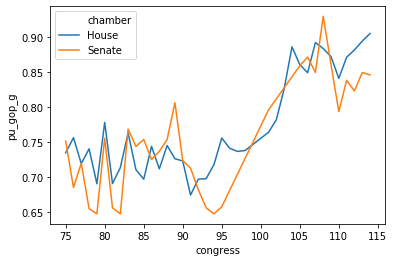

In [16]:
pu_gop_means = (vote_prod.groupby(['congress','chamber'])
            .agg(pu_gop = ('pu_gop',np.mean),
                 pu_gop_g = ('pu_gop',gmean))
            .reset_index()
           )
sns.lineplot(x = 'congress', y = 'pu_gop_g', hue = 'chamber', data = pu_gop_means)

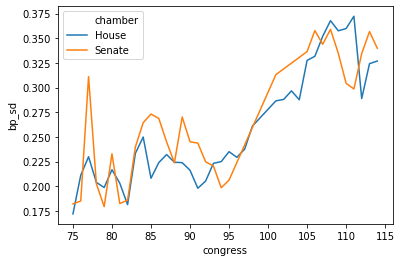

In [25]:
distis = (vote_prod.groupby(['congress','chamber'])
                    .agg(
                        bp_mu = ('bp_score',np.mean),
                        bp_mu_g = ('bp_score',gmean),
                        bp_sd = ('bp_score',np.std),
                        dem_mu = ('pu_dem',np.mean),
                        dem_mu_g = ('pu_dem',gmean),
                        dem_sd = ('pu_dem',np.std),
                        gop_mu = ('pu_gop',np.mean),
                        gop_mu_g = ('pu_gop',gmean),
                        gop_sd = ('pu_gop',np.std))
                    .reset_index()
                   )

sns.lineplot(x = 'congress', y = 'bp_sd', hue = 'chamber', data = distis);

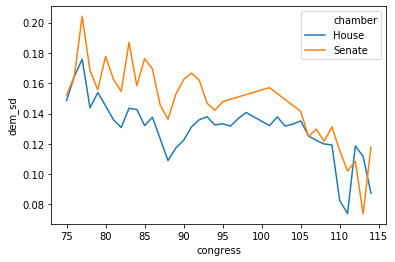

In [23]:
sns.lineplot(x = 'congress', y = 'dem_sd', hue = 'chamber', data = distis);

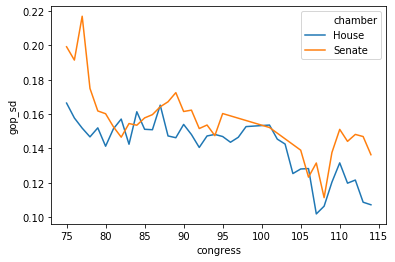

In [24]:
sns.lineplot(x = 'congress', y = 'gop_sd', hue = 'chamber', data = distis);